In [1]:
%load_ext autoreload
%autoreload 2
%run ~/FKMC/notebooks/notebook_preamble.py
%matplotlib inline
plt.style.use('../custom.mplstyle')

import multiprocessing as mp

np.seterr(under = 'ignore')
data_location = Path('~/HPC_data/pickled_data').expanduser()

Imported pathlib::Path, os, munch::Munch, pickle, logging, itertools::count, matplotlib::colors
Names are pyplot = plt, matplotlib = mpl, numpy = np


In [2]:
from pathlib import Path
import numpy as np
import os
from time import time, sleep
import sys
from munch import Munch
from itertools import product, islice
from FKMC.montecarlo import *

In [17]:
make_initial_state = lambda N: np.arange(N, dtype = np.float64) % 2 #a CDW initial state

T = 2.5
J = 5
U = 5
N = 4
R = 10
N_steps = 1000

In [18]:
parameters = dict(t = 1, alpha = 1.25, mu = 0, beta = 1/T, J = J, U = U, normalise = True)

perturb_log = []
for i in range(R):
    MCMC_params = dict(
        state = make_initial_state(N),
        N_steps = N_steps,
        N_burn_in = int(0),
        thin = 1,
        logger = Eigenspectrum_IPR_all(bins = 10000, limit = 20),
        proposal = p_one_or_two,
        accept_function = perturbation_accept,
        warnings = True,
        batch_info = False,
    )

    perturb_log.append(FK_mcmc(**MCMC_params, parameters = parameters, rng = np.random.default_rng(seed = 12345 + i)))

simple_log = []
for i in range(R):
    MCMC_params = dict(
            state = make_initial_state(N),
            N_steps = N_steps,
            N_burn_in = int(0),
            thin = 1,
            logger = Eigenspectrum_IPR_all(bins = 10000, limit = 20),
            proposal = p_one_or_two,
            accept_function = simple_accept,
            warnings = True,
            batch_info = False,
        )

    simple_log.append(FK_mcmc(**MCMC_params, parameters = parameters, rng = np.random.default_rng(seed = 12345 + i)))


def uniform_proposal(j, N_sites, rng, **kwargs):
    return np.where(rng.choice([0,1], size = N_sites))
    
MH_log = []
for i in range(R):
    MCMC_params = dict(
            state = make_initial_state(N),
            N_steps = N_steps,
            N_burn_in = int(0),
            thin = 1,
            logger = Eigenspectrum_IPR_all(bins = 10000, limit = 20),
            proposal = uniform_proposal,
            warnings = True,
            batch_info = False,
        )

    MH_log.append(FK_mcmc_MH(**MCMC_params, parameters = parameters))

Using default rng with OS etropy as a seed
RNG: Generator(PCG64), rng.bit_generator.state: {'bit_generator': 'PCG64', 'state': {'state': 284104311115764737757801888068023547683, 'inc': 6940913914820540084948225181445609167}, 'has_uint32': 0, 'uinteger': 0}
Using default rng with OS etropy as a seed
RNG: Generator(PCG64), rng.bit_generator.state: {'bit_generator': 'PCG64', 'state': {'state': 269982224279963799717629928160183109557, 'inc': 109186522290540882422335070360951292785}, 'has_uint32': 0, 'uinteger': 0}


/Users/tom/FKMC/FKMC/montecarlo.py:291: RuntimeWarning: invalid value encountered in double_scalars
  params_sans_matrix.update(J_matrix = 'suppressed for brevity')


Using default rng with OS etropy as a seed
RNG: Generator(PCG64), rng.bit_generator.state: {'bit_generator': 'PCG64', 'state': {'state': 6495837201142594137560496176082546380, 'inc': 226255787552880264165920911756642358789}, 'has_uint32': 0, 'uinteger': 0}
Using default rng with OS etropy as a seed
RNG: Generator(PCG64), rng.bit_generator.state: {'bit_generator': 'PCG64', 'state': {'state': 245612617485703336259820106426160028638, 'inc': 144202005200749403604904504619915579919}, 'has_uint32': 0, 'uinteger': 0}
Using default rng with OS etropy as a seed
RNG: Generator(PCG64), rng.bit_generator.state: {'bit_generator': 'PCG64', 'state': {'state': 338982315009534407172225689351402842082, 'inc': 88642312640856905414463155445124959923}, 'has_uint32': 0, 'uinteger': 0}
Using default rng with OS etropy as a seed
RNG: Generator(PCG64), rng.bit_generator.state: {'bit_generator': 'PCG64', 'state': {'state': 325063689851663071681578139128291593384, 'inc': 89427403015380031265305385447599763451}, 

In [6]:
def convert_states_to_ints(states):
    "convert [1,1,0] to 3 and so on"
    return np.int64((states * (2**np.arange(states.shape[-1]))).sum(axis = -1))

def generate_all_state(N):
    assert(N <= 8)
    return np.unpackbits(np.arange(2**N, dtype = np.uint8)[:, None], axis = 1, count = N, bitorder = 'little')

assert(np.allclose(convert_states_to_ints(generate_all_state(N = 6)), np.arange(2**6, dtype = np.int64)))

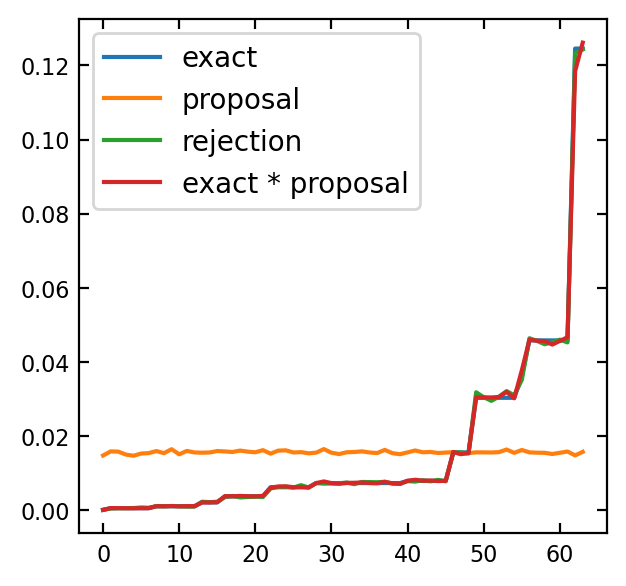

In [13]:
from FKMC.montecarlo import Ff, rejection_sample_q


def p_zero_one_or_two(j, N_sites, rng, **kwargs):
    n_sites = rng.integers(0,3)
    return rng.integers(low=0, high=N_sites, size=n_sites, dtype=int)

def prop(state, rng, parameters, proposal, proposal_args = dict()):
    state = state.copy()
    sites = proposal(0, len(state), rng, **proposal_args)
    state[sites] = 1 - state[sites]
    return state
    

def L1_normalise(x): return x / x.sum()

repeats = 100000
N = 6
rng = np.random.default_rng(seed = 0)
state = make_initial_state(N)
proposal = uniform_proposal

parameters = dict(t = 1, alpha = 1.25, mu = 0, beta = 1/T, J = J, U = U, normalise = True)
parameters.update(J_matrix = interaction_matrix(N, dtype = np.float64, **parameters))

#first get the distribution of the directly sampled proposal distribution
states = np.array([prop(state, rng, parameters, proposal) for _ in range(repeats)])
ids = convert_states_to_ints(states)
dist0 = L1_normalise(np.bincount(ids, minlength=2**N))

#now get the distribution of the rejection sampled new proposal distribution
states = np.array([rejection_sample_q(state, rng, parameters, proposal, proposal_args = dict()) for _ in range(repeats)])
ids = convert_states_to_ints(states)
dist1 = L1_normalise(np.bincount(ids, minlength=2**N))

Ffs = np.array([Ff(s, **parameters) for s in generate_all_state(N)])
Ff0 = Ff(make_initial_state(N), **parameters)

exact =  L1_normalise(np.minimum(1, np.exp(- parameters['beta'] * (Ffs - Ff0))))

idx = np.argsort(exact)

plt.plot(exact[idx], label = 'exact')
plt.plot(dist0[idx], label = 'proposal')
plt.plot(dist1[idx], label = 'rejection')
plt.plot(L1_normalise(exact[idx] * dist0[idx]), label = 'exact * proposal')
plt.legend()

In [9]:
from FKMC.general import interaction_matrix
from FKMC.plotting import spread
from FKMC.general import solve_H_vectorised

def expected_Ps(N):
    states = generate_all_state(N)
    parameters = dict(t = 1, alpha = 1.25, mu = 0, beta = 1/T, J = J, U = U, normalise = True)
    parameters.update(J_matrix = interaction_matrix(N, dtype = np.float64, **parameters))
    Ff, Fc, evals, evecs = solve_H_vectorised(states, **parameters)
    F = Ff + Fc
    Zs = np.exp(-parameters['beta'] * F)
    return Zs / np.sum(Zs)

expected_Ps(4)

array([0.01372103, 0.03827404, 0.03846963, 0.02345094, 0.03846963,
       0.28576352, 0.02357716, 0.03827404, 0.03827404, 0.02357716,
       0.28576352, 0.03846963, 0.02345094, 0.03846963, 0.03827404,
       0.01372103])

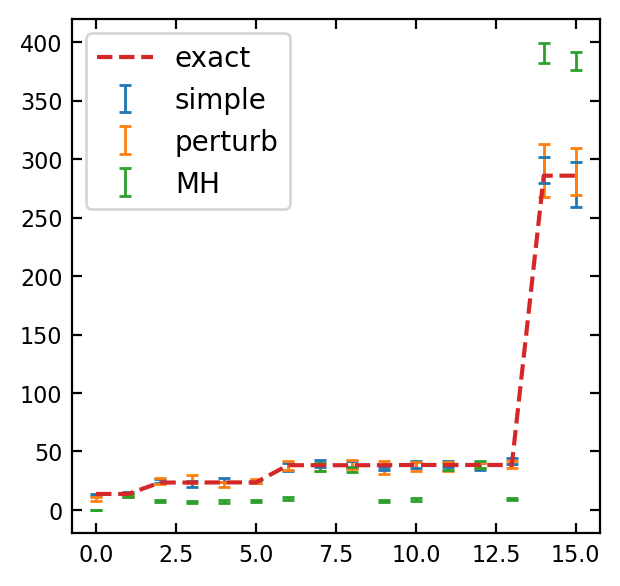

In [19]:
#calculate P(state) for all states starting from 
Ps = expected_Ps(N)
idx = np.argsort(Ps)

def count_state_appearances(log):
    state_ids = np.int64((log.state * (2**np.arange(log.state.shape[-1]))).sum(axis = -1))
    N_states = log.state.shape[-1]
    counts = np.bincount(state_ids, minlength=2**N_states)
    return counts

f, ax = plt.subplots()
for logs, label in zip([simple_log, perturb_log, MH_log], ['simple','perturb','MH']):
    counts = np.array([count_state_appearances(log) for log in logs])[:, idx]
    mean_counts = np.mean(counts, axis = 0)
    sem_counts = scipy.stats.sem(counts, axis = 0)
    
    #spread(ax, X = np.arange(2**N), Y = mean_counts, dY = sem_counts, label = label)
    ax.errorbar(np.arange(2**N), mean_counts, yerr = sem_counts, label = label, linestyle='None', capsize = 2, elinewidth = 1, capthick = 1)
    
ax.plot(np.arange(2**N), Ps[idx] * N_steps, label = 'exact', linestyle = '--')
    
ax.legend()

In [20]:
from FKMC.disorder_model import FK_disorder_model
from numpy.random import default_rng
from FKMC.montecarlo import Eigenspectrum_IPR_all

logger = Eigenspectrum_IPR_all(bins = 2000, limit = 5)
rng = default_rng()

parameters = dict(t = 1, alpha = 1.25, mu = 0, beta = 1/T, J = J, U = U, normalise = True)
parameters.update(J_matrix = interaction_matrix(N, dtype = np.float64, **parameters))


states = rng.choice((0,1), size = (N_steps, N))    
FK_disorder_model(states, logger = logger, parameters = parameters, rng = rng)

NameError: name 'Is_todo' is not defined